## Texture Descriptors: Local Binary Patterns (LBP)

The base pipeline is given: Extract lbp features + label encoding + minmax scaling + stratified k fold + classifier (linear regression for now)

In [1]:
# Load Libraries
import os
import sys; sys.path.insert(0, os.path.abspath("../"))
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import skimage
from scipy.stats import skew, kurtosis
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage.feature import local_binary_pattern
from dataset.dataset import SkinLesion_Dataset, SegExamples
from pipeline.preprocessing import SkinLesionPreprocessing
from sklearn.model_selection import StratifiedKFold
from statistics import stdev
from sklearn import linear_model

preproc = SkinLesionPreprocessing()
data = SegExamples()

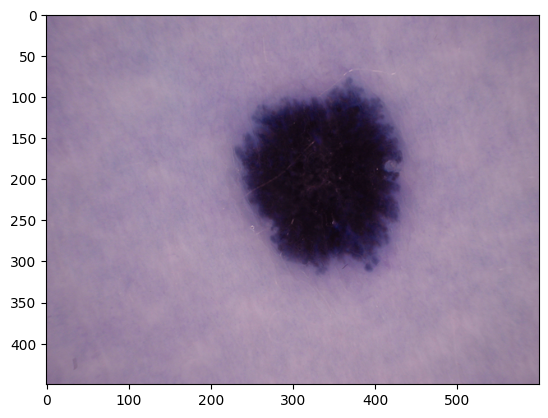

In [2]:
image = data[0]['img']
plt.imshow(image)

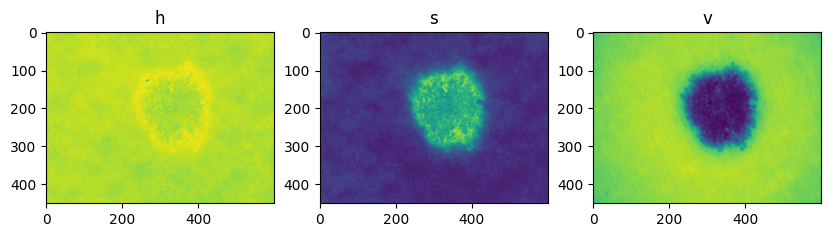

In [6]:
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
f,axes = plt.subplots(1,3,figsize=(10,10))
axes = axes.ravel()
ch_n = ['h','s','v']
for i,ax in enumerate(axes):
    ax.imshow(image_hsv[:,:,i]),ax.set_title(f'{ch_n[i]}')

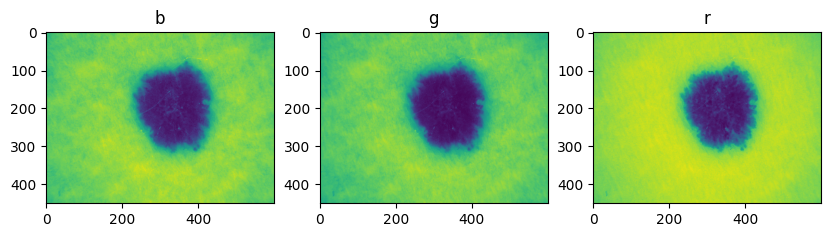

In [7]:
f,axes = plt.subplots(1,3,figsize=(10,10))
axes = axes.ravel()
ch_n = ['b','g','r']
for i,ax in enumerate(axes):
    ax.imshow(image[:,:,i]), ax.set_title(f'{ch_n[i]}')

In [7]:
lbp = local_binary_pattern(image[:,:,2],8,3,method='uniform')
hist = np.histogram(lbp.ravel())
hist

(array([20792, 24732, 12995, 13283, 14912, 15770, 15383, 29470, 29693,
        92970]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))

### trying local features

In [8]:
lbp = local_binary_pattern(image[:,:,2],8,1,method='uniform')
hist = np.histogram(lbp.ravel())
hist

(array([18855, 24057, 14948, 21882, 22720, 25216, 24053, 27883, 38186,
        52200]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))

In [15]:
lbp_roi = local_binary_pattern(mask*image_p[:,:,2],8,1,method='uniform')
hist_roi = np.histogram(lbp_roi.ravel())
hist_roi

(array([  1490,   2168,   2210,   5039,   7296,   6061,   3419,   2531,
        230273,   4137]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))

In [27]:
lbp_bbox = local_binary_pattern(image_p[rect[1]:(rect[1]+rect[3]),rect[0]:(rect[0]+rect[2]),2],
                                8,1,method='uniform')
hist_bbox = np.histogram(lbp_bbox.ravel())
hist_bbox

(array([2222, 3007, 2877, 5690, 8312, 7115, 4321, 3604, 6297, 5821]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))

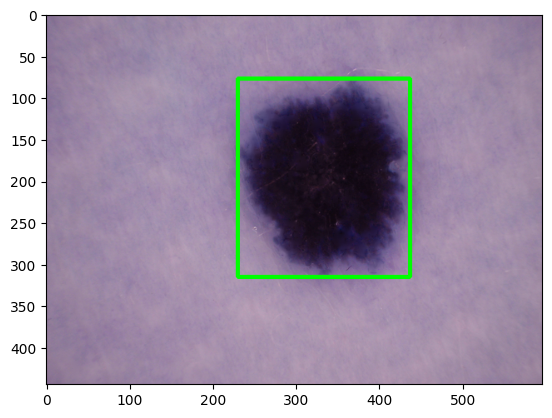

In [18]:
def segment(img):

    r_norm = img[:,:,2]*(1/np.sqrt(np.sum(img.astype(np.float32)**2, axis=-1)))
    rnormg = (cv2.GaussianBlur(r_norm, ksize = (0,0), sigmaX=3, borderType = cv2.BORDER_DEFAULT)*255).astype(np.uint8)
    _,mask_r = cv2.threshold(rnormg, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Filling holes
    contour_r,_ = cv2.findContours(mask_r,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour_r:
        cv2.drawContours(mask_r,[cnt],0,255,-1)
    
    return mask_r

image_p = preproc.preprocess(image)
mask = segment(image_p)
rect = cv2.boundingRect(mask)
bbox_image = cv2.rectangle(image_p, (rect[0], rect[1]),(rect[0]+rect[2],rect[1]+rect[3]),(0,255,0),3)
plt.imshow(bbox_image)

In [23]:
image_p[rect[1]:(rect[1]+rect[3]),rect[0]:(rect[0]+rect[2]),2]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [ 26,  25,  24, ..., 146,   0,   0],
       [ 26,  24,  26, ..., 147,   0,   0],
       [ 26,  27,  27, ..., 147,   0,   0]], dtype=uint8)

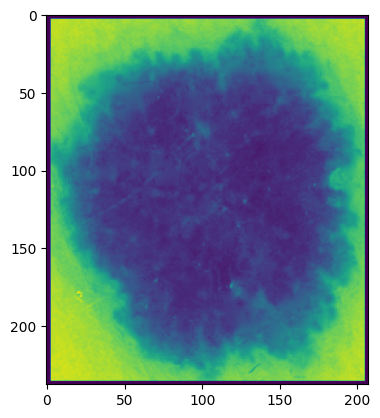

In [26]:
plt.imshow(image_p[rect[1]:(rect[1]+rect[3]),rect[0]:(rect[0]+rect[2]),2])

In [17]:
rect = cv2.boundingRect(mask)
rect

(230, 77, 207, 238)

In [31]:
radius = 1
n_points = 8 * radius
lbp_feature_vector = []

for ch in range(3):
    lbp = local_binary_pattern(image_p[:,:,ch], n_points, radius, method="uniform")
    hist = np.histogram(lbp.ravel())[0].astype(np.float32)
    hist = hist/(hist.sum() + np.finfo(np.float32).eps)
    lbp_feature_vector.extend(np.ndarray.tolist(hist))
lbp_feature_vector

[0.06442348659038544,
 0.08452370017766953,
 0.05838850513100624,
 0.08922471106052399,
 0.0937783420085907,
 0.10408353060483932,
 0.08957615494728088,
 0.0960683822631836,
 0.13827921450138092,
 0.1816539764404297,
 0.05471915006637573,
 0.07491005957126617,
 0.051559947431087494,
 0.09319638460874557,
 0.10468816012144089,
 0.12244921177625656,
 0.09592478722333908,
 0.09789739549160004,
 0.13420173525810242,
 0.17045317590236664,
 0.06868991255760193,
 0.08842357248067856,
 0.053596802055835724,
 0.07976222783327103,
 0.08411179482936859,
 0.09310191124677658,
 0.08636783063411713,
 0.1011057198047638,
 0.15505774319171906,
 0.18978248536586761]

### cansu extraction

In [3]:
# settings for LBP
# Compute the rotation invariant uniform (frequent) LBP features
# Gray scale LBP
binary_data = data.seg_examples_df.iloc[:60] # only nevus vs others
paths = "../data/"+binary_data.path

# Create Binary Labels for the sample binary dataset
binary_labels = []
for p in binary_data.path:
     binary_labels.append(p.split('/')[2])
binary_labels = pd.DataFrame(binary_labels)
label_encoder = preprocessing.LabelEncoder()

def lbp_function(paths):
    radius = 1
    n_points = 8 * radius
    lbp_feature_vector=[]
    for i in paths:
        image = cv2.imread(i, cv2.IMREAD_GRAYSCALE) # read image as grayscale
        lbp = local_binary_pattern(image, n_points, radius, method="uniform") # 'uniform' is rotation invariant.
        hist = np.histogram(lbp.ravel())
        feature_array=np.ndarray.tolist(hist[0])
        lbp_feature_vector.append(feature_array)
    return pd.DataFrame(lbp_feature_vector)

(array([ 32752.,  50577.,  17370.,  72636.,  85644., 120208.,  52069.,
         79234., 420069., 118017.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

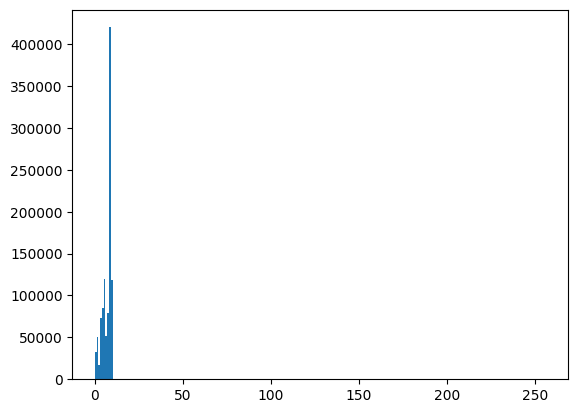

In [21]:
radius = 1
n_points = 8 * radius
lbp_feature_vector=[]
image = cv2.imread(paths[1], cv2.IMREAD_GRAYSCALE) # read image as grayscale
image_rgb = cv2.imread(paths[1],cv2.IMREAD_COLOR) # read image as grayscale
lbp = local_binary_pattern(image, n_points, radius, method="uniform") # 'uniform' is rotation invariant.
hist = np.histogram(lbp.ravel())
plt.hist(lbp.ravel(),256,[0,256])
# feature_array=np.ndarray.tolist(hist[0])
# lbp_feature_vector.append(feature_array)

(array([ 32752.,  50577.,  17370.,  72636.,  85644., 120208.,  52069.,
         79234., 420069., 118017.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

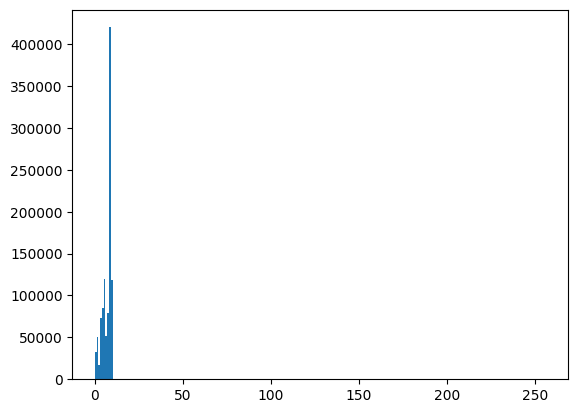

In [22]:
lbp_rgb = local_binary_pattern(image_rgb[:,:,2], n_points, radius, method="uniform") # 'uniform' is rotation invariant.
plt.hist(lbp.ravel(),256,[0,256])

In [22]:
df = lbp_function(paths)
df['label'] = label_encoder.fit_transform(binary_labels[0]) # add binary labels
df

,0,1,2,3,4,5,6,7,8,9,label
0,11175,18382,11056,27568,31619,38299,26568,27658,35824,41851,0
1,32752,50577,17370,72636,85644,120208,52069,79234,420069,118017,0
2,84362,95319,41044,62585,58294,77699,76937,119955,197095,235286,0
3,12817,22783,14350,29035,49311,29132,21261,25759,27192,38360,0
4,51041,85057,45705,100709,93264,124879,105947,105429,156252,180293,0
5,30703,60995,36163,128309,136303,181624,105114,93327,147866,128172,0
6,28073,48533,31650,117717,155663,174094,83612,81546,218805,108883,0
7,49790,76545,26934,85139,82337,116537,74716,96165,254324,186089,0
8,31635,61815,36737,123092,183880,170855,99252,83916,127931,129463,0
9,26856,40967,33813,138701,310033,188733,57567,58535,103218,90153,0


In [23]:
def classifier(df):
    x = df.loc[:, df.columns != 'label']
    y = df['label']

    scaler = preprocessing.MinMaxScaler()
    x_scaled = scaler.fit_transform(x)

    # Create  classifier object.
    lr = linear_model.LogisticRegression()
    # lr = svm.SVC()

    # Create StratifiedKFold object.
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
    lst_accu_stratified = []

    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        lr.fit(x_train_fold, y_train_fold)
        lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))

    # Print the output.
    print('List of possible accuracy:', lst_accu_stratified)
    print('\nMaximum Accuracy That can be obtained from this model is:',
          max(lst_accu_stratified)*100, '%')
    print('\nMinimum Accuracy:',
          min(lst_accu_stratified)*100, '%')
    print('\nOverall Accuracy:',
          np.mean(lst_accu_stratified)*100, '%')
    print('\nStandard Deviation is:', stdev(lst_accu_stratified))

In [24]:
classifier(df)

List of possible accuracy: [0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666]

Maximum Accuracy That can be obtained from this model is: 66.66666666666666 %

Minimum Accuracy: 66.66666666666666 %

Overall Accuracy: 66.66666666666667 %

Standard Deviation is: 0.0
